<b>Exercise and Non-Exercise Predictors of Heart Disease</b>

Heart disease (HD) has many symptoms, thus, diagnosis is difficult, and it is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). The question we are asking is: Can exercise-related parameters can more accurately diagnose HD than non-exercise-related predictors? We will create one model classifying non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression during exercise, angina during exercise, and slope (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0-4 (Detrano, n.d.).

In [1]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
# Installation of the required libraries to conduct our data analysis. Setting of the seed to ensure our analysis is reproducible (Detrano, n.d.).
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("data/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


WRANGLING THE DATA:

In [4]:
# Set the dataset's column names to the variable descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

In [5]:
# Mutate the result column into a factor, so it can be used to color and fill the graphs.
cleveland_data <- mutate(cleveland_data, result = as_factor(result))

# Wrangling the data by creating the desired datasets.
# First Dataset: data collected from patients in the non-exercise state.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Second Dataset: data collected from patients after exercise.
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

head(cleveland_data_resting)
head(cleveland_data_exercise)

# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.
cleveland_data_resting_mean <- map_df(cleveland_data_resting, mean)
cleveland_data_exercise_mean <- map_df(cleveland_data_exercise, mean)
cleveland_data_resting_mean
cleveland_data_exercise_mean

age,resting_blood_pressure,resting_electrocardio,result
<dbl>,<dbl>,<dbl>,<fct>
63,145,2,0
67,160,2,2
67,120,2,1
37,130,0,0
41,130,2,0
56,120,0,0


exercise_angina,exercise_st,exercise_slope,result
<dbl>,<dbl>,<dbl>,<fct>
0,2.3,3,0
1,1.5,2,2
1,2.6,2,1
0,3.5,3,0
0,1.4,1,0
0,0.8,1,0


Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,resting_blood_pressure,resting_electrocardio,result
<dbl>,<dbl>,<dbl>,<dbl>
54.43894,131.6898,0.990099,NA


exercise_angina,exercise_st,exercise_slope,result
<dbl>,<dbl>,<dbl>,<dbl>
0.3267327,1.039604,1.60066,NA


We wrangled the data to create our datasets from the processed.cleveland.data (Detrano, n.d.). Our first dataset includes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as in many experiments its correlation to HD has been identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of the most important risk factors for cardiovascular disease” (Wu et al., 2015). Our second dataset includes exercise-related predictors. ST depression during exercise is used as it is related to HD outcome, thus having medical value (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study the involvement of exercise testing for HD predictions, correlating to the extent of illness (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis (Detrano, n.d.). 

Our preliminary summary includes the mean of each variable to understand their ranges. Due to the disparity in their means, we will be required to scale them for modeling.

SPLITTING INTO TRAINING/TESTING:

We will perform a $K$-nearest neighbors classification, using tidymodels, thus we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data to build accurate models (Timbers et al., 2022). 

In [6]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

VISUALIZING THE DATA:

Our preliminary visualization is in histograms as our predictors are either binary or adopt a range of values. The predictors’ values are on the x-axis and diagnoses, from 0 (no HD) to 4 (severe HD) are on the y-axis. 

GROUP 1 GRAPHS:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



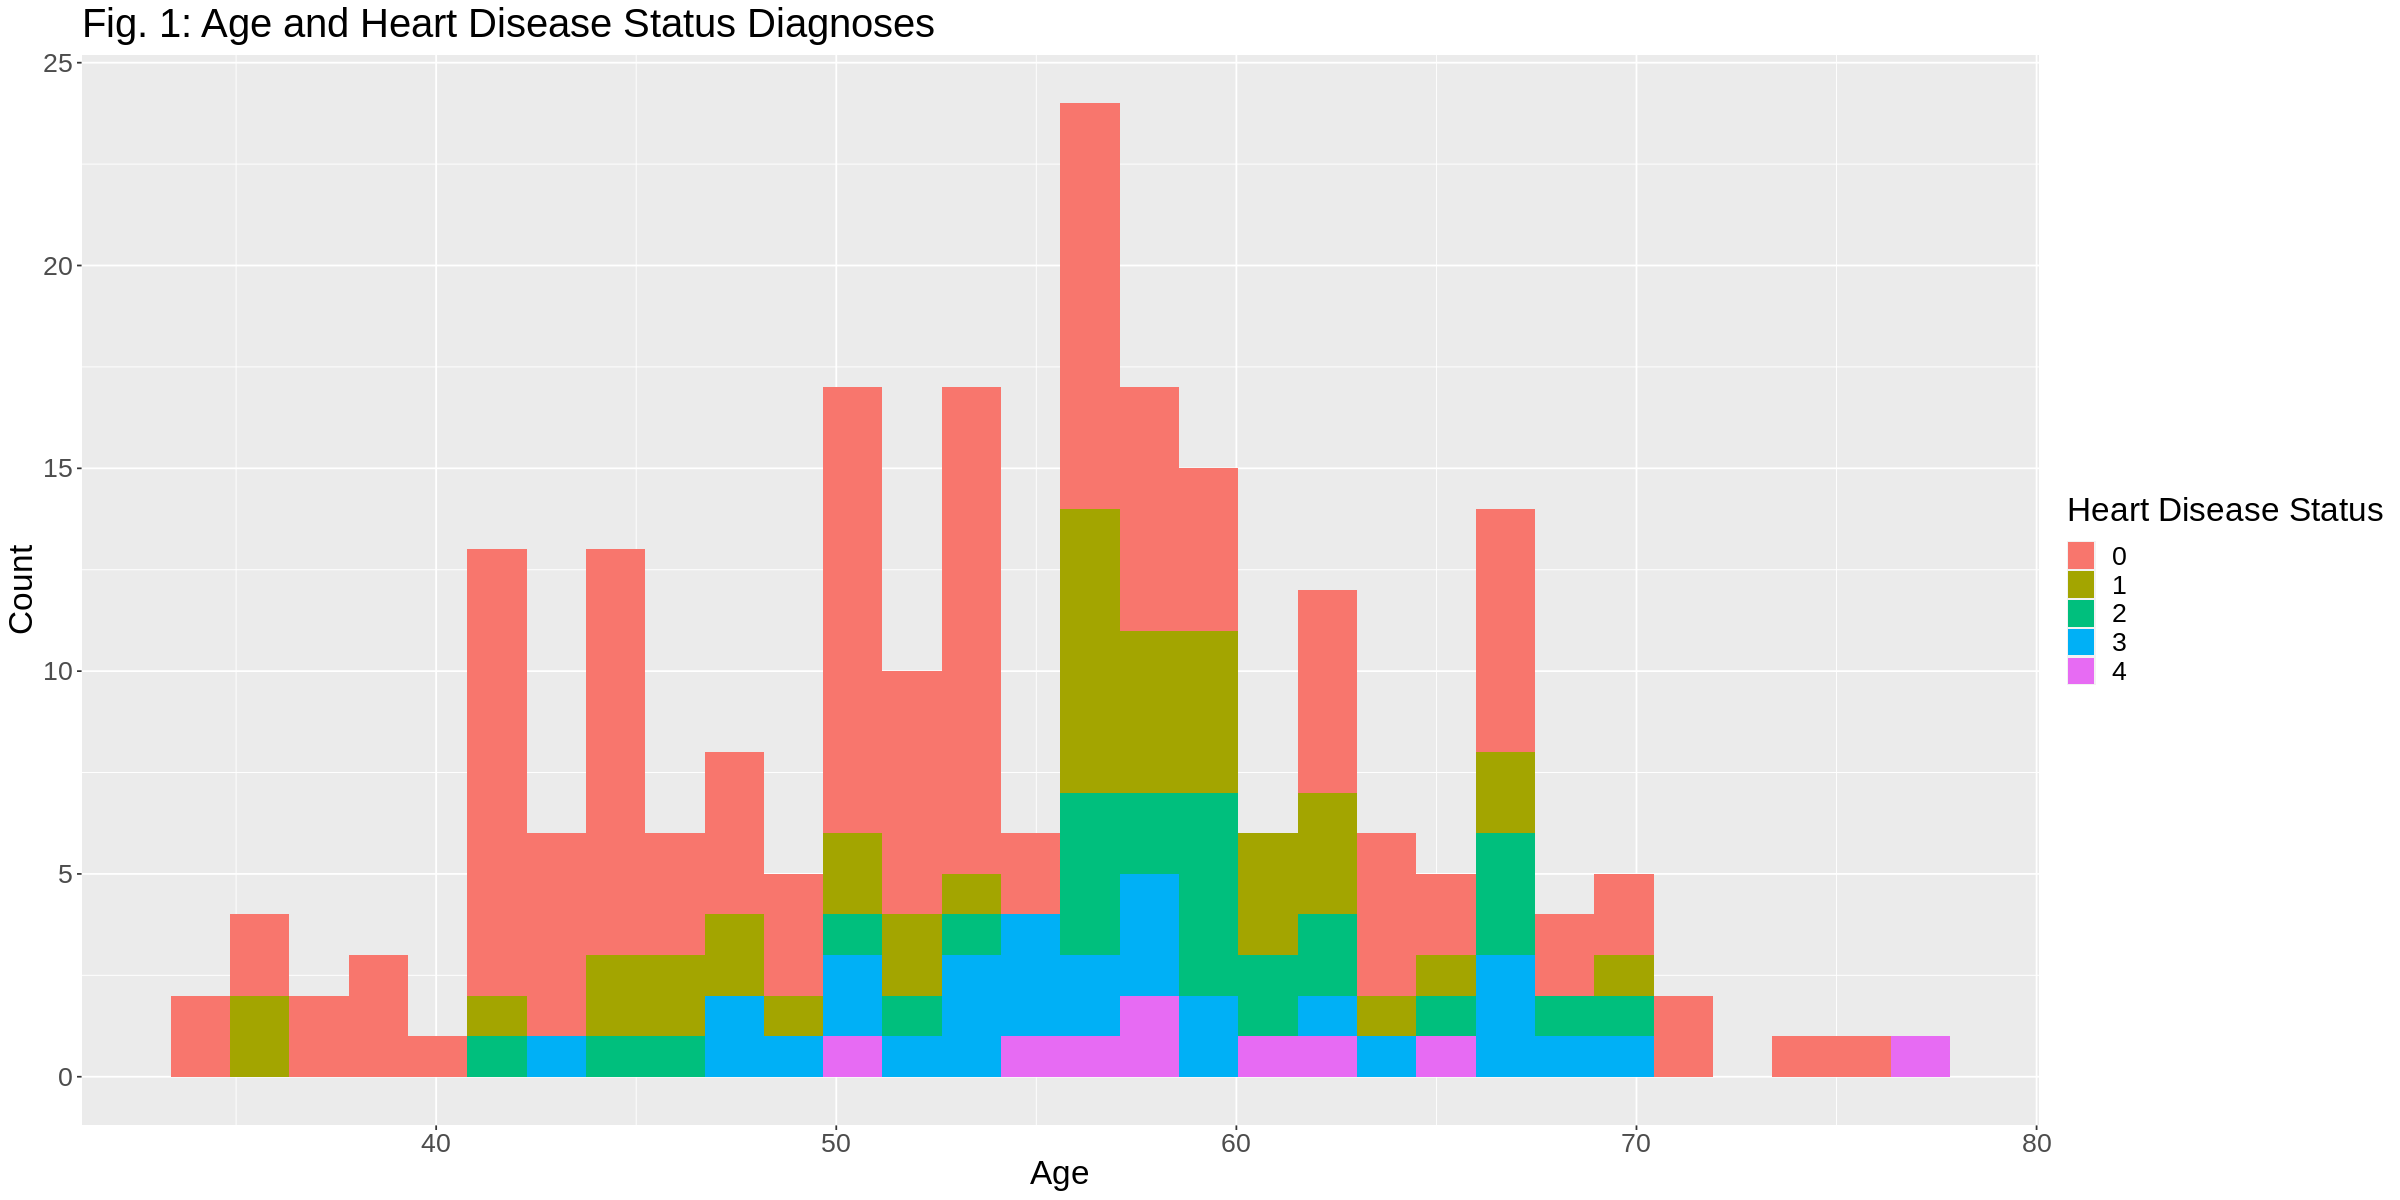

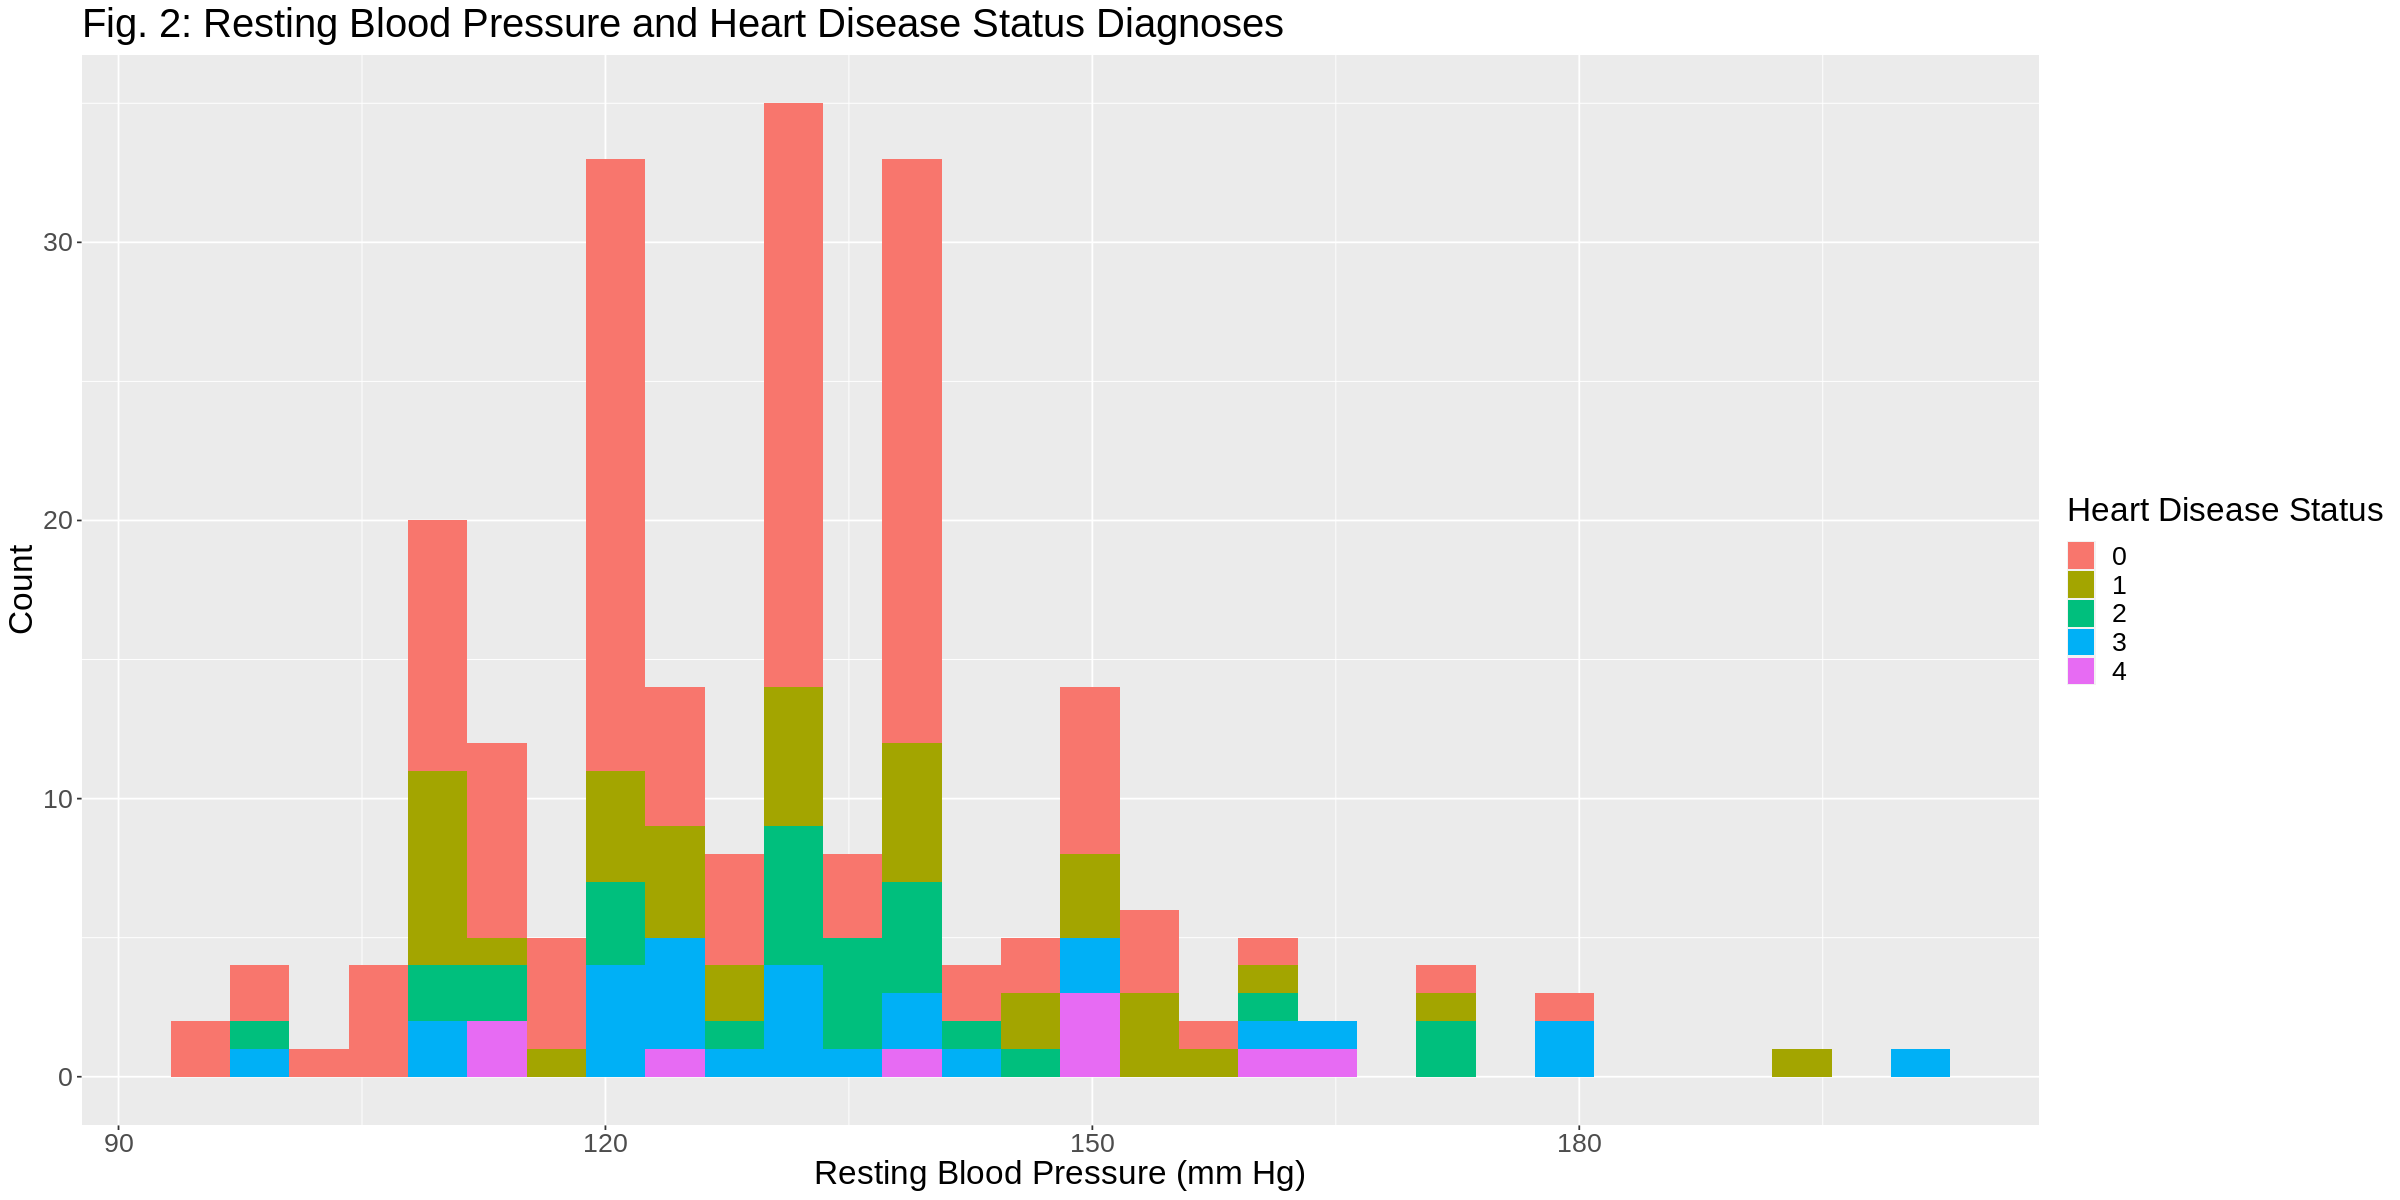

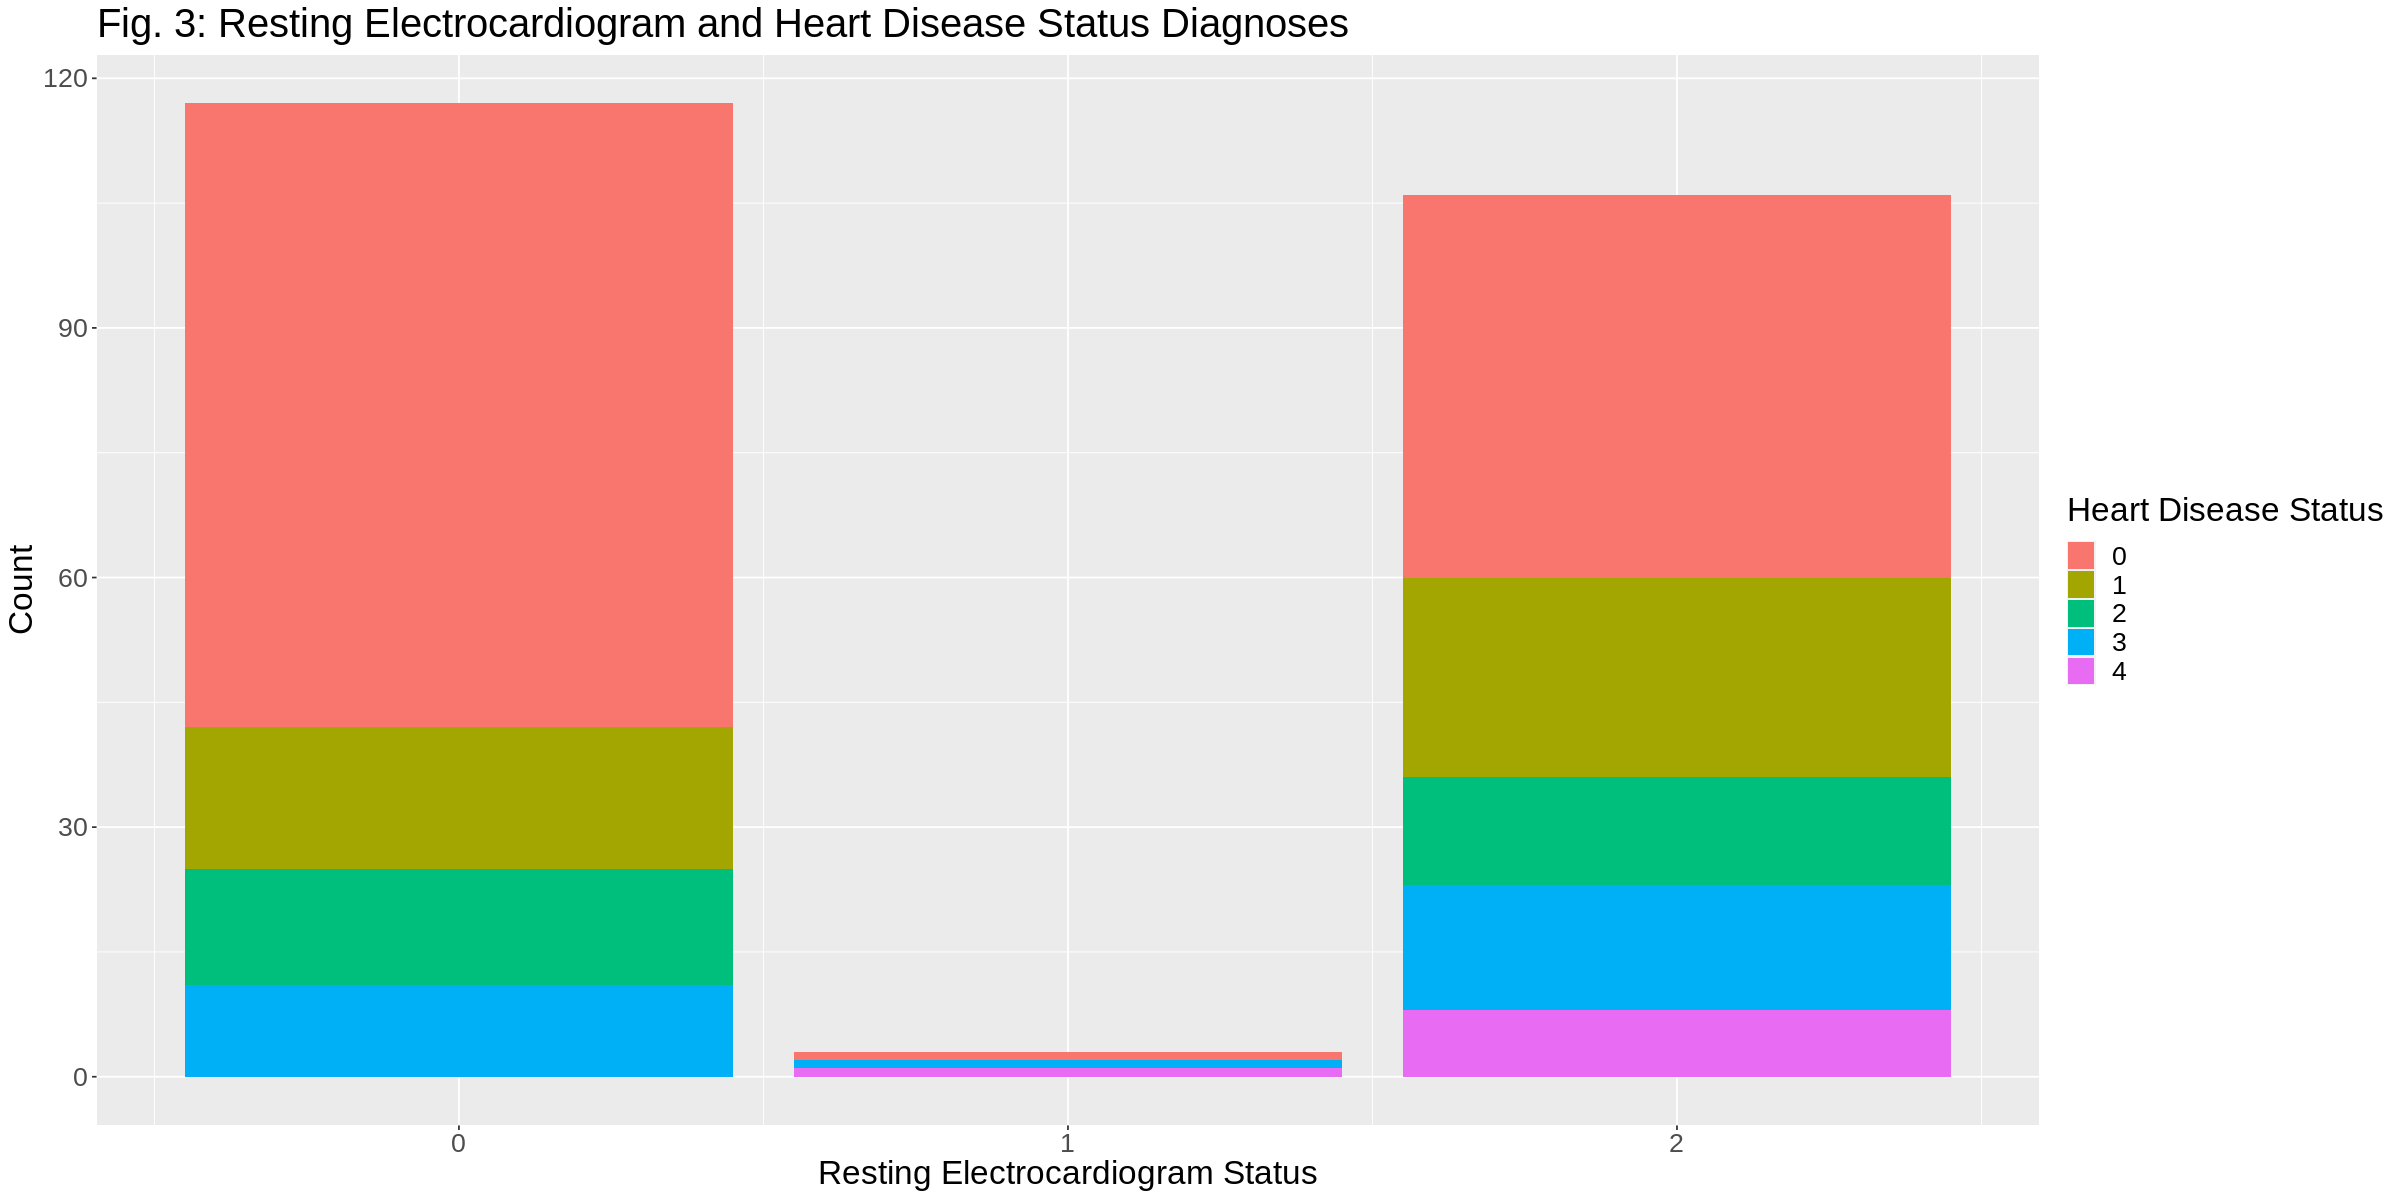

In [7]:
#Creating the plots to visualize the predictors from the first dataset in relation to the severity of heart disease. 
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 20, repr.plot.height = 10) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_age_plot

resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_bps_plot

resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
    ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Resting Electrocardiogram Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
resting_electro_plot

GROUP 2 GRAPHS:


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



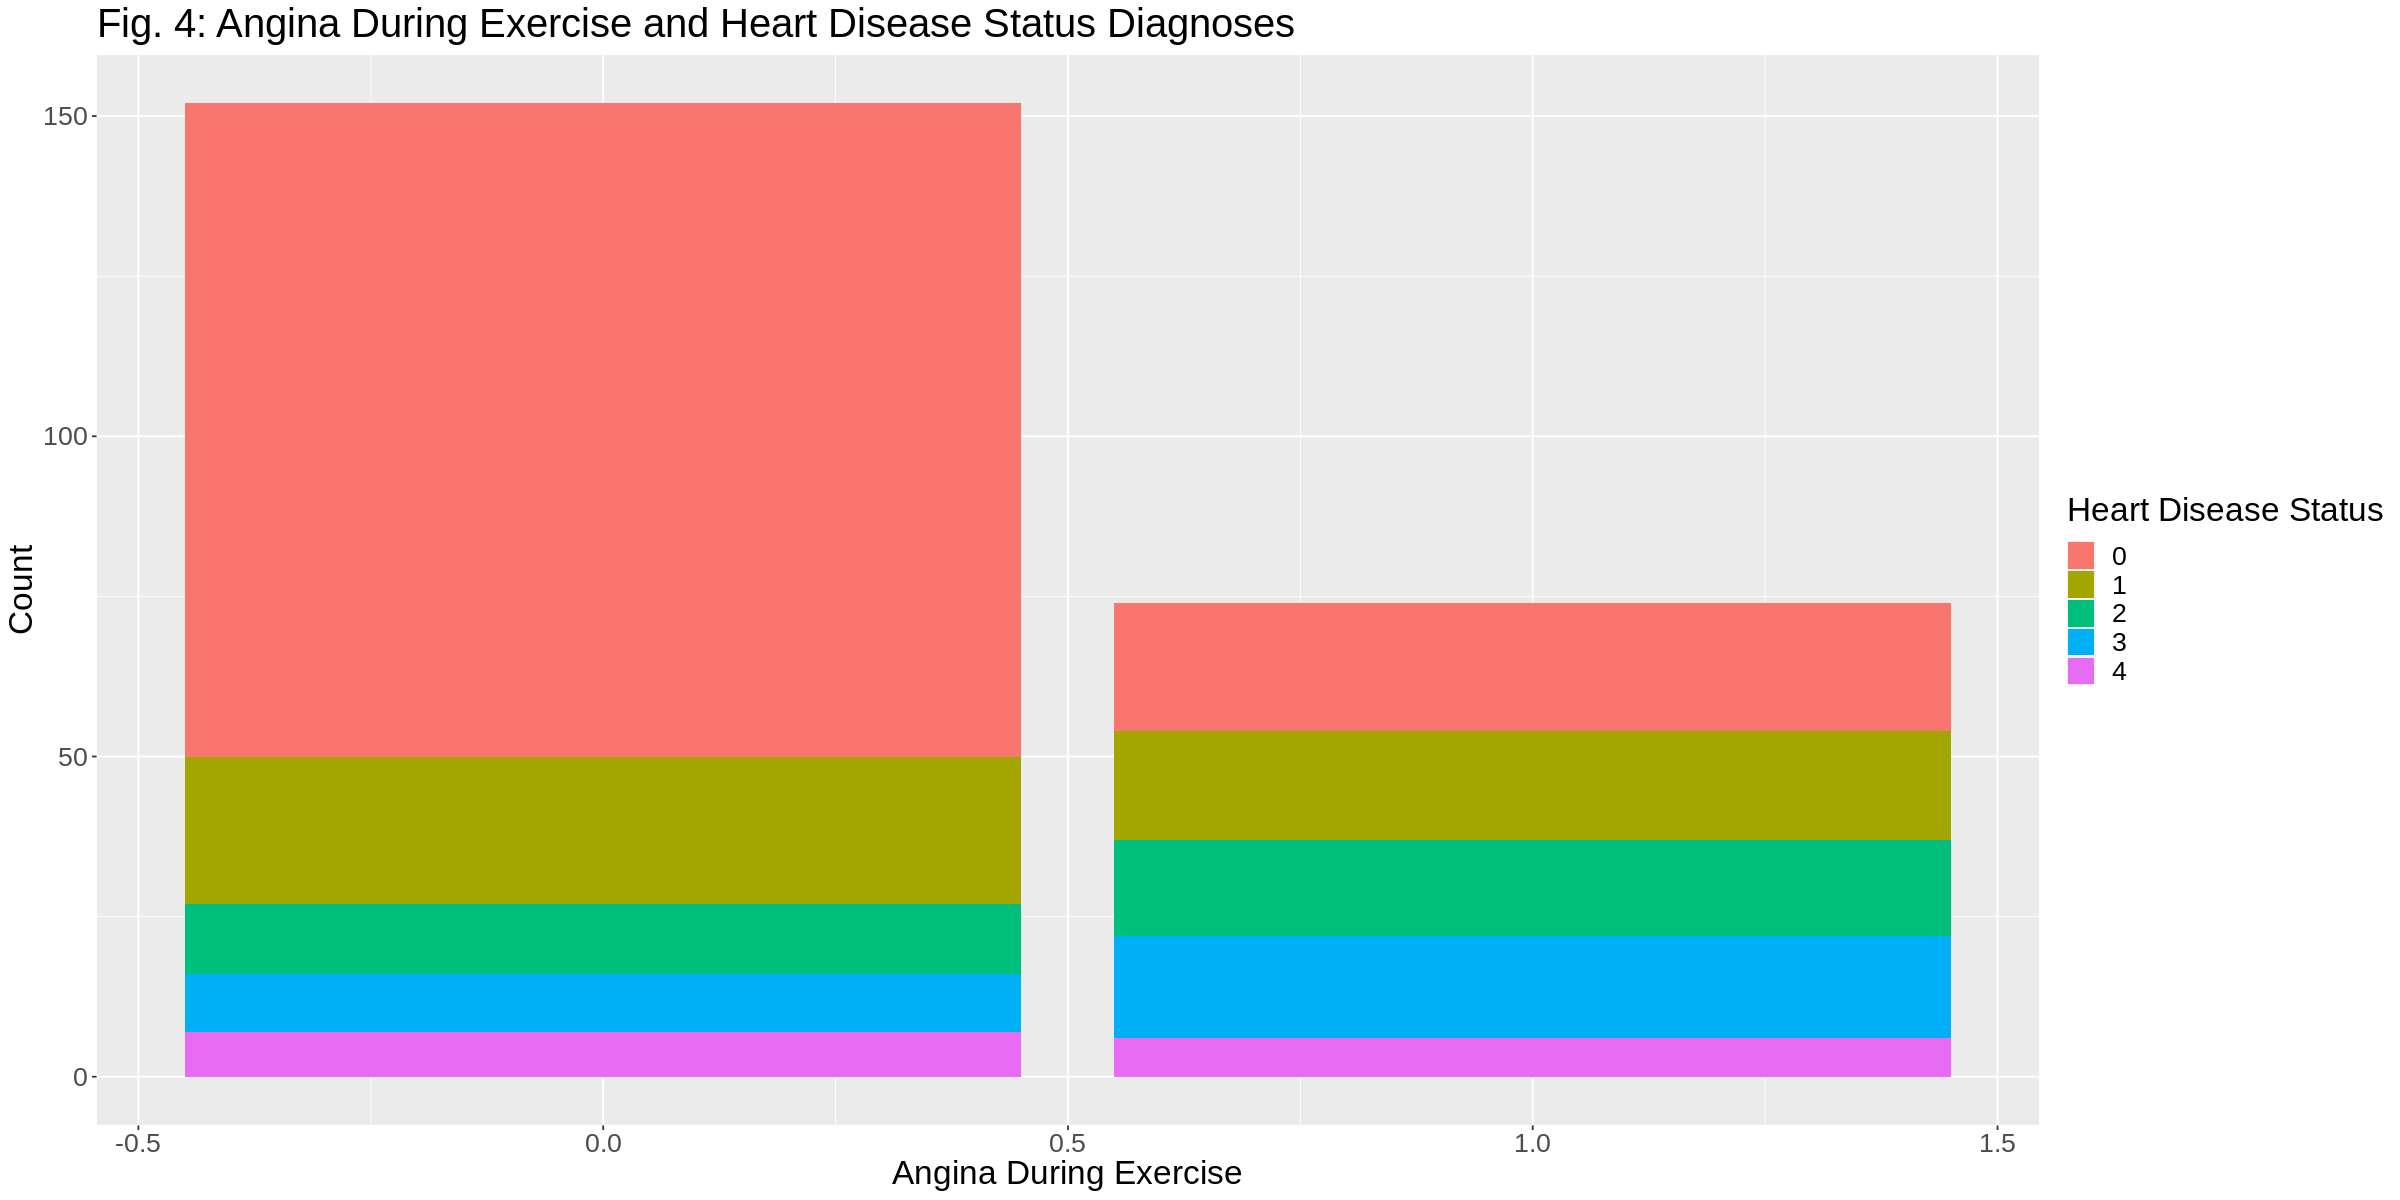

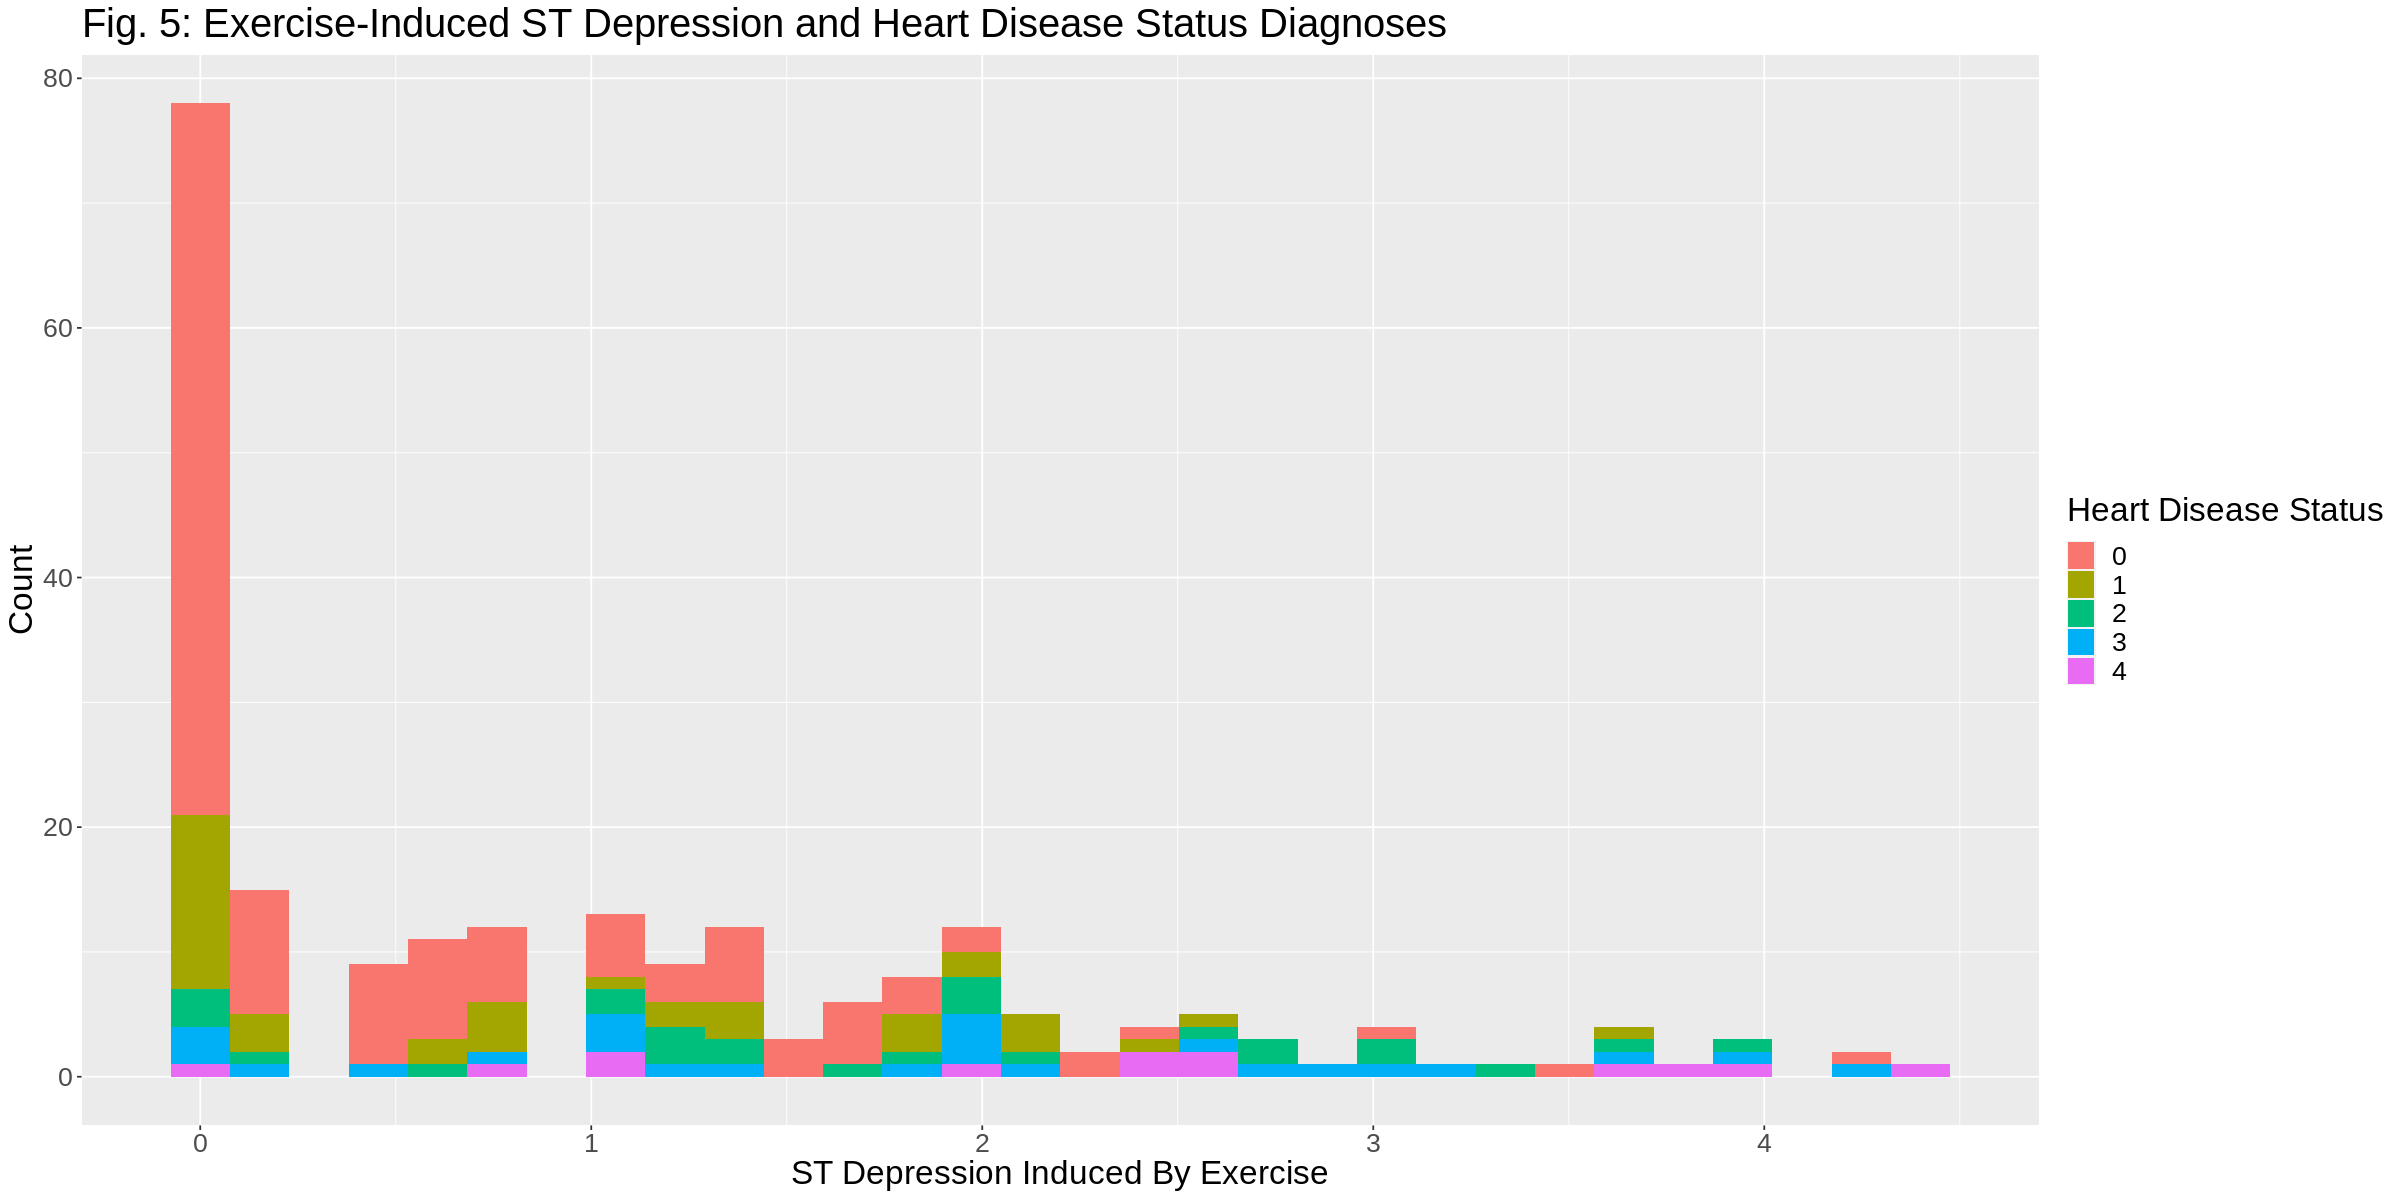

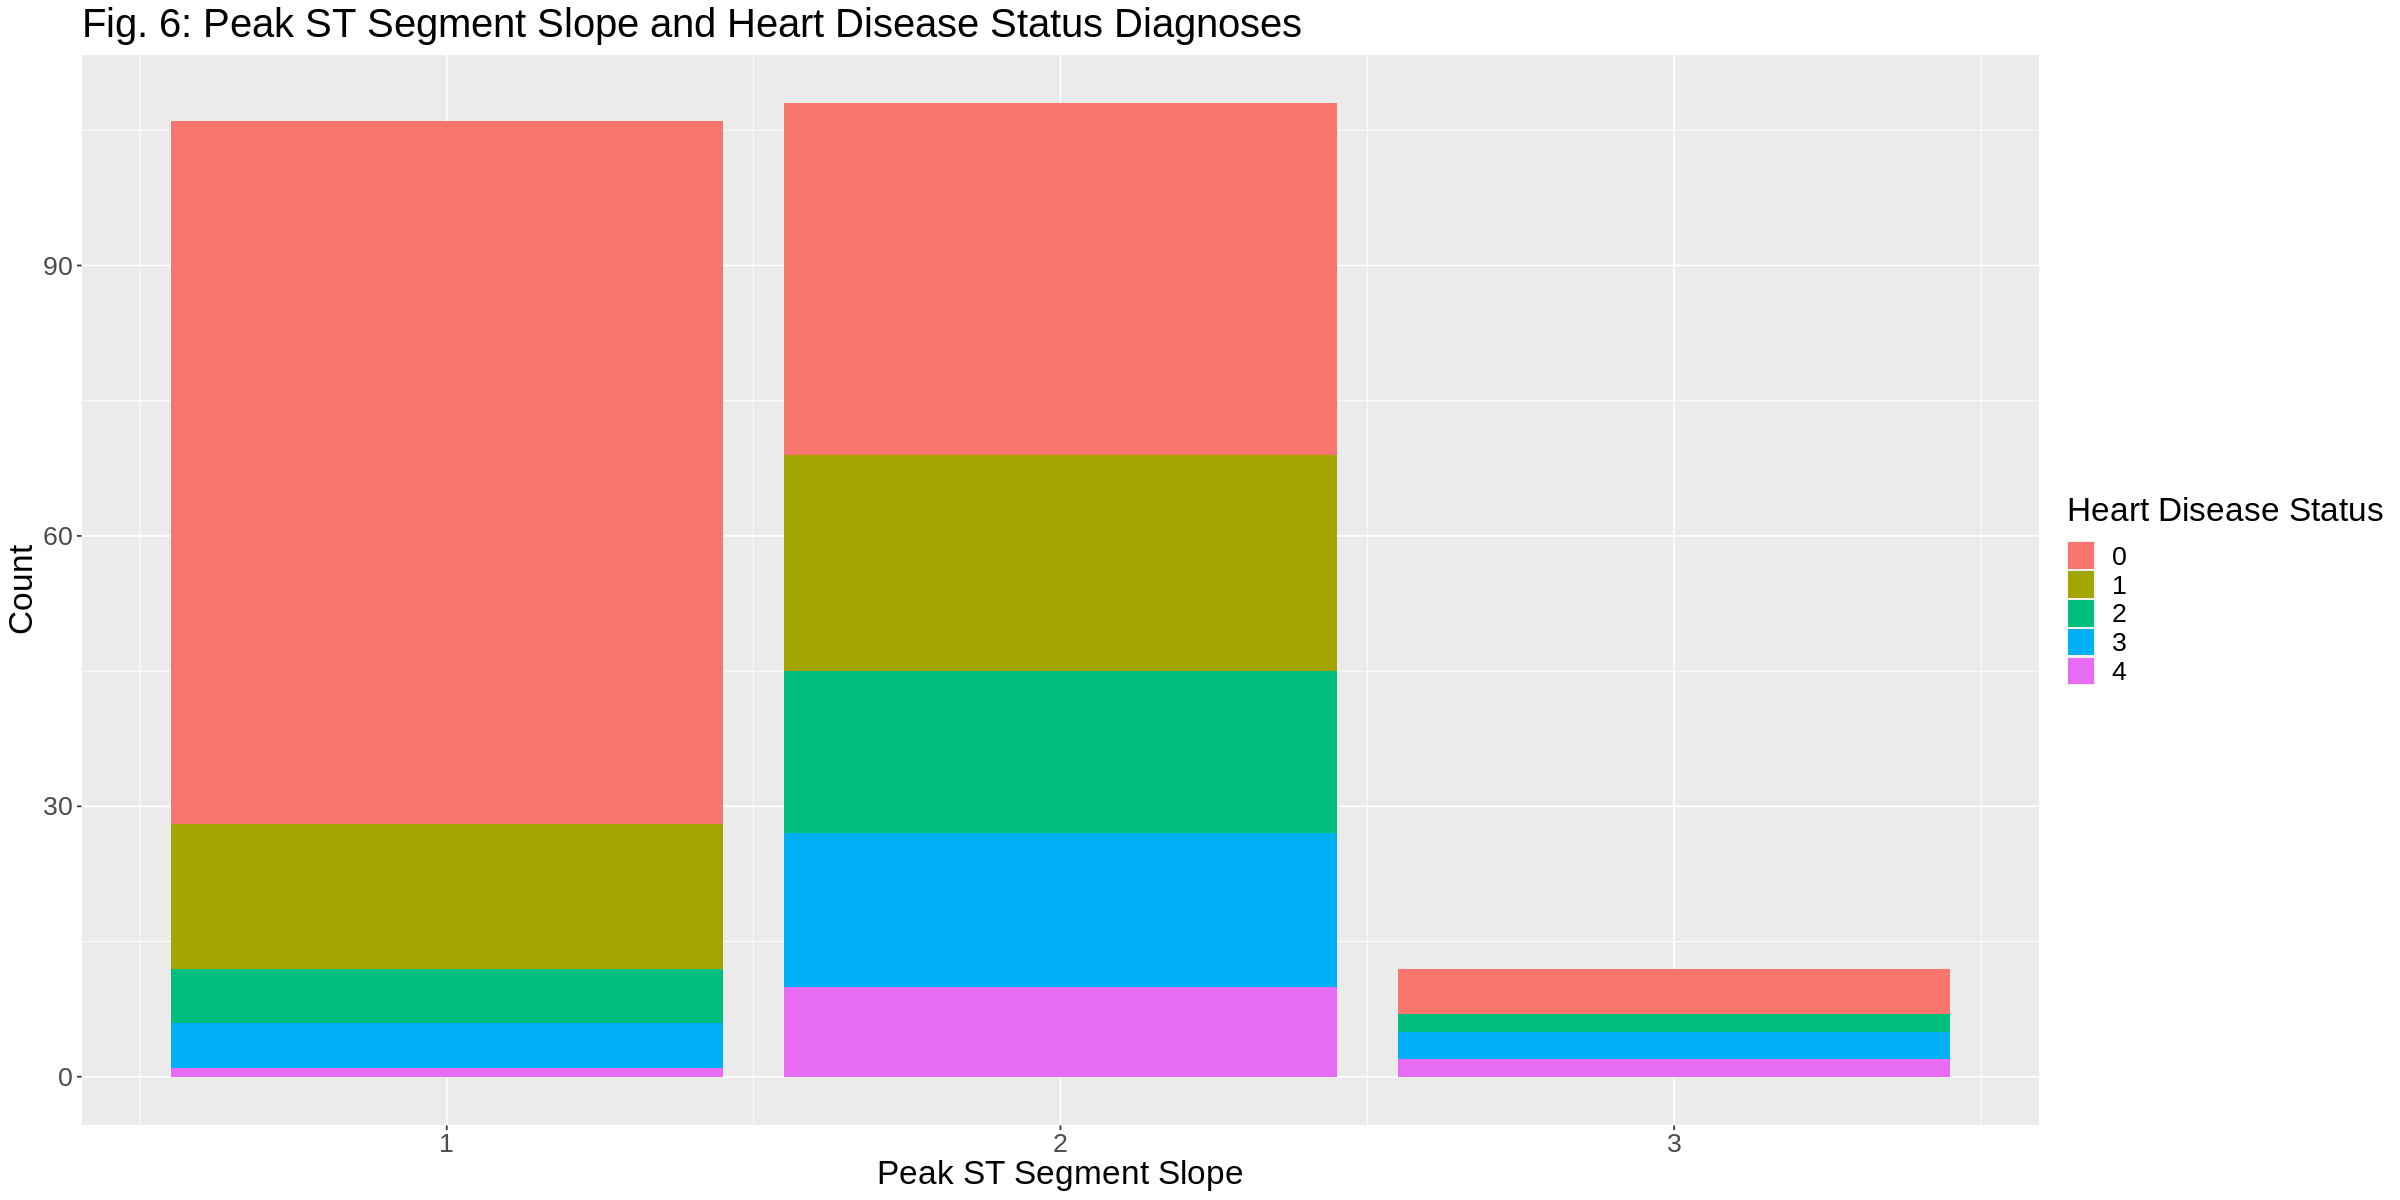

In [8]:
#Creating the plots to visualize the predictors in the second data set in relation to the severity of heart disease.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
exercise_angina <- ggplot(exercise_train, aes(x = exercise_angina)) +
    ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_angina

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +

    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("ST Depression Induced By Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_st_plot

exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Peak ST Segment Slope and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Peak ST Segment Slope") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 20))
exercise_slope_plot

In [9]:
# Creating a recipe for the classification using the resting data. 

resting_recipe <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = resting_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

In [10]:
# Creating a model for the classification that we can tune to find the best K. 

resting_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

In [22]:
# Creating a cross validation set. 

resting_vfold <- vfold_cv(resting_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 2))
                   
# Creating a workflow to determine the best K. 

resting_model_workflow <- workflow() |>
                            add_recipe(resting_recipe) |>
                            add_model(resting_model_tune) |>
                            tune_grid(resamples = resting_vfold, grid = k_to_try) |>
                            collect_metrics()

! Fold01: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold08: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold09: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



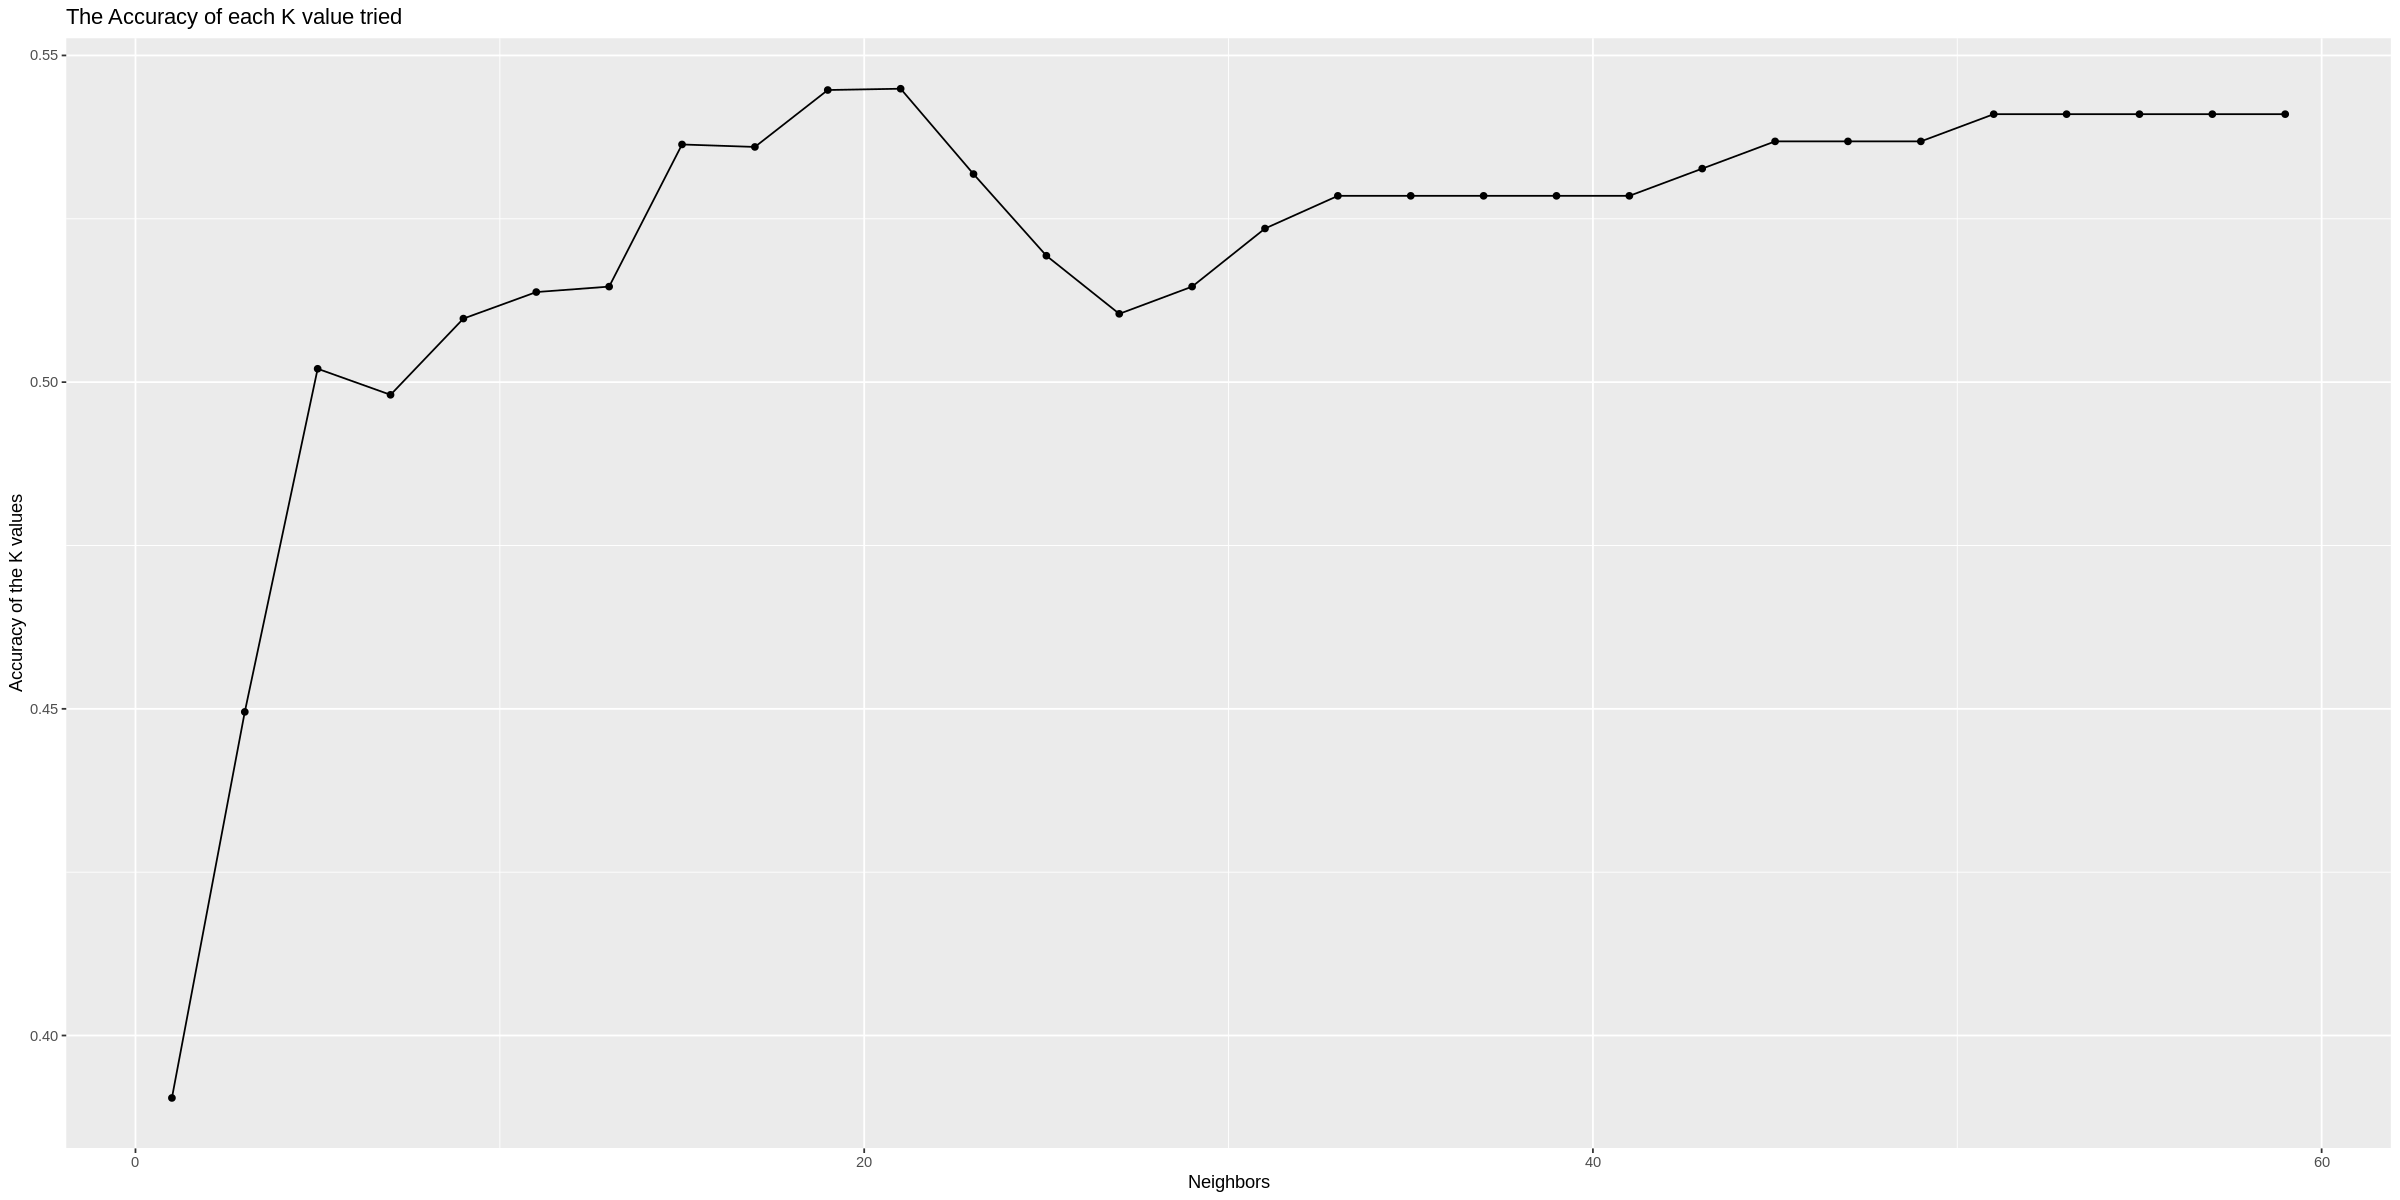

In [23]:
# Filtering the accuracy of each K from the metrics.

accuracy_of_k <- resting_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

accuracy_plot <- accuracy_of_k |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("The Accuracy of each K value tried")
accuracy_plot

From the above plot, we will choose K=19 to build this model. This is because this K generates this highest accuracy, while still having the K values adjacent to it being relatively accurate as well. 

In [25]:
# Creating a new model which includes the K to generate the best fit. 

best_resting_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_resting_fit <- workflow() |>
                        add_recipe(resting_recipe) |>
                        add_model(best_resting_model) |>
                        fit(data = resting_train)

# Fitting the model to our testing data to make the predictions. 

resting_predictions <- best_resting_fit |>
                        predict(resting_test) |>
                        bind_cols(resting_test)

.pred_class,age,resting_blood_pressure,resting_electrocardio,result
<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,67,160,2,2
0,62,140,2,3
0,57,120,0,0
⋮,⋮,⋮,⋮,⋮
0,44,120,0,2
0,63,140,2,2
0,38,138,0,0


In [28]:
# Looking at the metrics and confusion matrix for this model to determine its accuracy.

resting_metrics <- resting_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
resting_metrics

resting_conf_mat <- resting_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
resting_conf_mat

[1] 0.4805195

          Truth
Prediction  0  1  2  3  4
         0 36 13  7  6  3
         1  6  1  2  2  1
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

To conduct our analysis, we will  scale and center our data to create a model. This requires cross-validation to determine each dataset’s optimal $K$, then our model will be fit to the testing data to classify the patients by diagnosis. Our goal is to determine the most accurate model, evaluating the metrics and confusion matrix for each. To visualize our results we will create a bar plot denoting the number of correct/incorrect predictions in the testing dataset for each model to determine their accuracy.  

In conclusion, we are determining whether exercise or non-exercise predictors are more effective at diagnosing HD. We expect that having patients exercise before diagnosis will be a more effective strategy than without analyzing physical effort. This can impact diagnostic accuracy, by expanding our range of diagnostic tests. While it could be more time-consuming than traditional methods, and unrealistic in extreme situations, it could lead to questioning how we can apply the most appropriate diagnostic method in all patient circumstances. 

Word count: 499 words

<b>References:</b>

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. British Journal of General Practice, 60(575), 246-257. 10.3399/bjgp10X502137

Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Harvard Health Publishing. (2021, September 21). Angina: Symptoms, diagnosis and treatments. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-andtreatments#:~:text=September%2021%2C%202021,by%20cholesterol%2Dclogged%20coronary%20arteries.

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. Heart. 90(12). 1417-1421. 10.1136/hrt.2003.031260

Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. PLoS ONE, 14(5), https://doi.org/10.1371/journal.pone.0216534

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine (Baltimore). 94(47). 10.1097/MD.0000000000002160
